In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)

In [11]:
inspector.get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

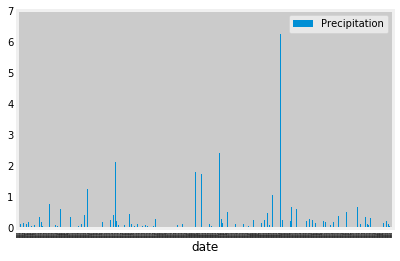

In [39]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
    #from 2016-8-23 to 2017-8-23
# Perform a query to retrieve the date and precipitation scores
measurement_df = pd.read_sql(session.query(Measurement.date, Measurement.prcp.label('Precipitation')).filter(Measurement.date >= '2016-08-23').statement, session.bind)
# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = measurement_df.dropna().set_index("date")
# Sort the dataframe by date
measurement_df = measurement_df.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data
measurement_df.plot(kind="bar")
plt.gca().axes.tick_params(axis='x', labelsize=0)
plt.show()

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
inspector.get_columns('station')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'name',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'latitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'longitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'elevation',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
MostActive = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
MostActive

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == MostActive[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

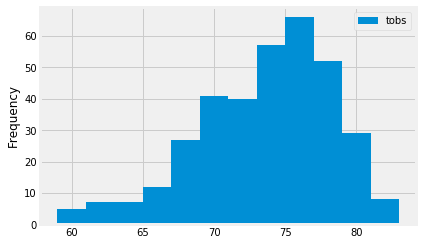

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_df = pd.read_sql(session.query(Measurement.date,Measurement.station,Measurement.tobs).statement,session.bind)
temperature_df = temperature_df.dropna(how="any").sort_values(by="date", ascending=False)
temperature_group = temperature_df.groupby("station").agg({"tobs":"count"})
temperature_group = temperature_group.sort_values(by="tobs", ascending=False)
temperature_df = temperature_df.loc[(temperature_df["station"]==temperature_group.index[0]) & (temperature_df["date"]>"2016-08-23")]
temperature_df.plot(kind="hist", bins=12)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))
Trip_Avg_Temp = calc_temps('2012-02-28', '2012-03-05')[0]
print(Trip_Avg_Temp[1])

[(62.0, 69.57142857142857, 74.0)]
69.57142857142857


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#My vacation occurs from 2017-07-05 to 2017-07-15
print(calc_temps('2016-07-05','2017-07-15'))

[(58.0, 74.66538789428814, 87.0)]


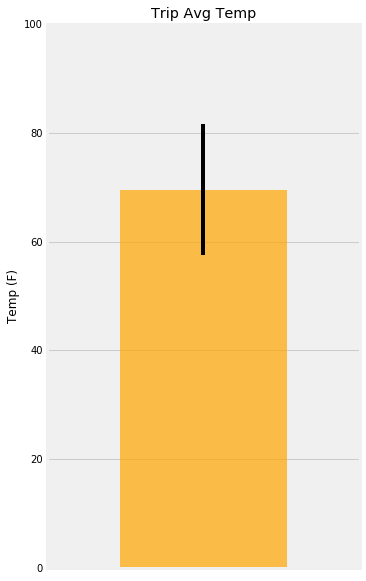

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(5,10))
plt.bar(x=1,height=Trip_Avg_Temp[1],yerr=(Trip_Avg_Temp[2]-Trip_Avg_Temp[0]),color="orange", alpha = 0.7)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xlim(0.25,1.75)
plt.ylim(0,100)
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).filter(Measurement.date>='2016-07-05',Measurement.date<='2016-07-15',Measurement.station==Station.station).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  7.569999999999999),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  3.0000000000000004),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  1.6400000000000001),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.45),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.1099999999999999),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.53),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
